In [1]:
import os
import itertools

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout,BatchNormalization

import warnings
warnings.filterwarnings('ignore')

print("Modules Loaded")

/Users/nguyen.vo.int/Downloads/brain-tumor-classification-main/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Modules Loaded


In [2]:
root_path = os.path.dirname(os.getcwd())

In [4]:
data_dir = os.path.join(root_path, "brain_tumor_44_classes")
filepaths = []
labels = []

folds = os.listdir(data_dir)

for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    
    # Check if the path is a directory before listing its contents
    if os.path.isdir(foldpath):
        filelist = os.listdir(foldpath)
        
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold.split(' ')[0])
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='labels')

df = pd.concat([FSeries, LSeries], axis=1)


In [5]:
df['labels'].value_counts()

labels
Meningioma           874
Astrocitoma          580
_NORMAL              522
Schwannoma           465
Neurocitoma          457
Carcinoma            251
Papiloma             237
Oligodendroglioma    224
Glioblastoma         204
Ependimoma           150
Tuberculoma          145
Meduloblastoma       131
Germinoma            100
Granuloma             78
Ganglioglioma         61
Name: count, dtype: int64

In [6]:
train_df, dummy_df = train_test_split(df, train_size=0.8, random_state=42, stratify=df['labels'])

valid_df, test_df = train_test_split(dummy_df, train_size=0.5, random_state=42, stratify=dummy_df['labels'])

In [7]:
batch_size = 32
image_size = (224, 224)

gen = ImageDataGenerator()

train_gen = gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', class_mode='categorical',
                                   color_mode = 'rgb', target_size=image_size, batch_size=batch_size)

valid_gen = gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', class_mode='categorical',
                                   color_mode = 'rgb', target_size=image_size, batch_size=batch_size)

test_gen = gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', class_mode='categorical',
                                   color_mode = 'rgb', target_size=image_size, batch_size=batch_size)

Found 3583 validated image filenames belonging to 15 classes.
Found 447 validated image filenames belonging to 15 classes.
Found 448 validated image filenames belonging to 15 classes.


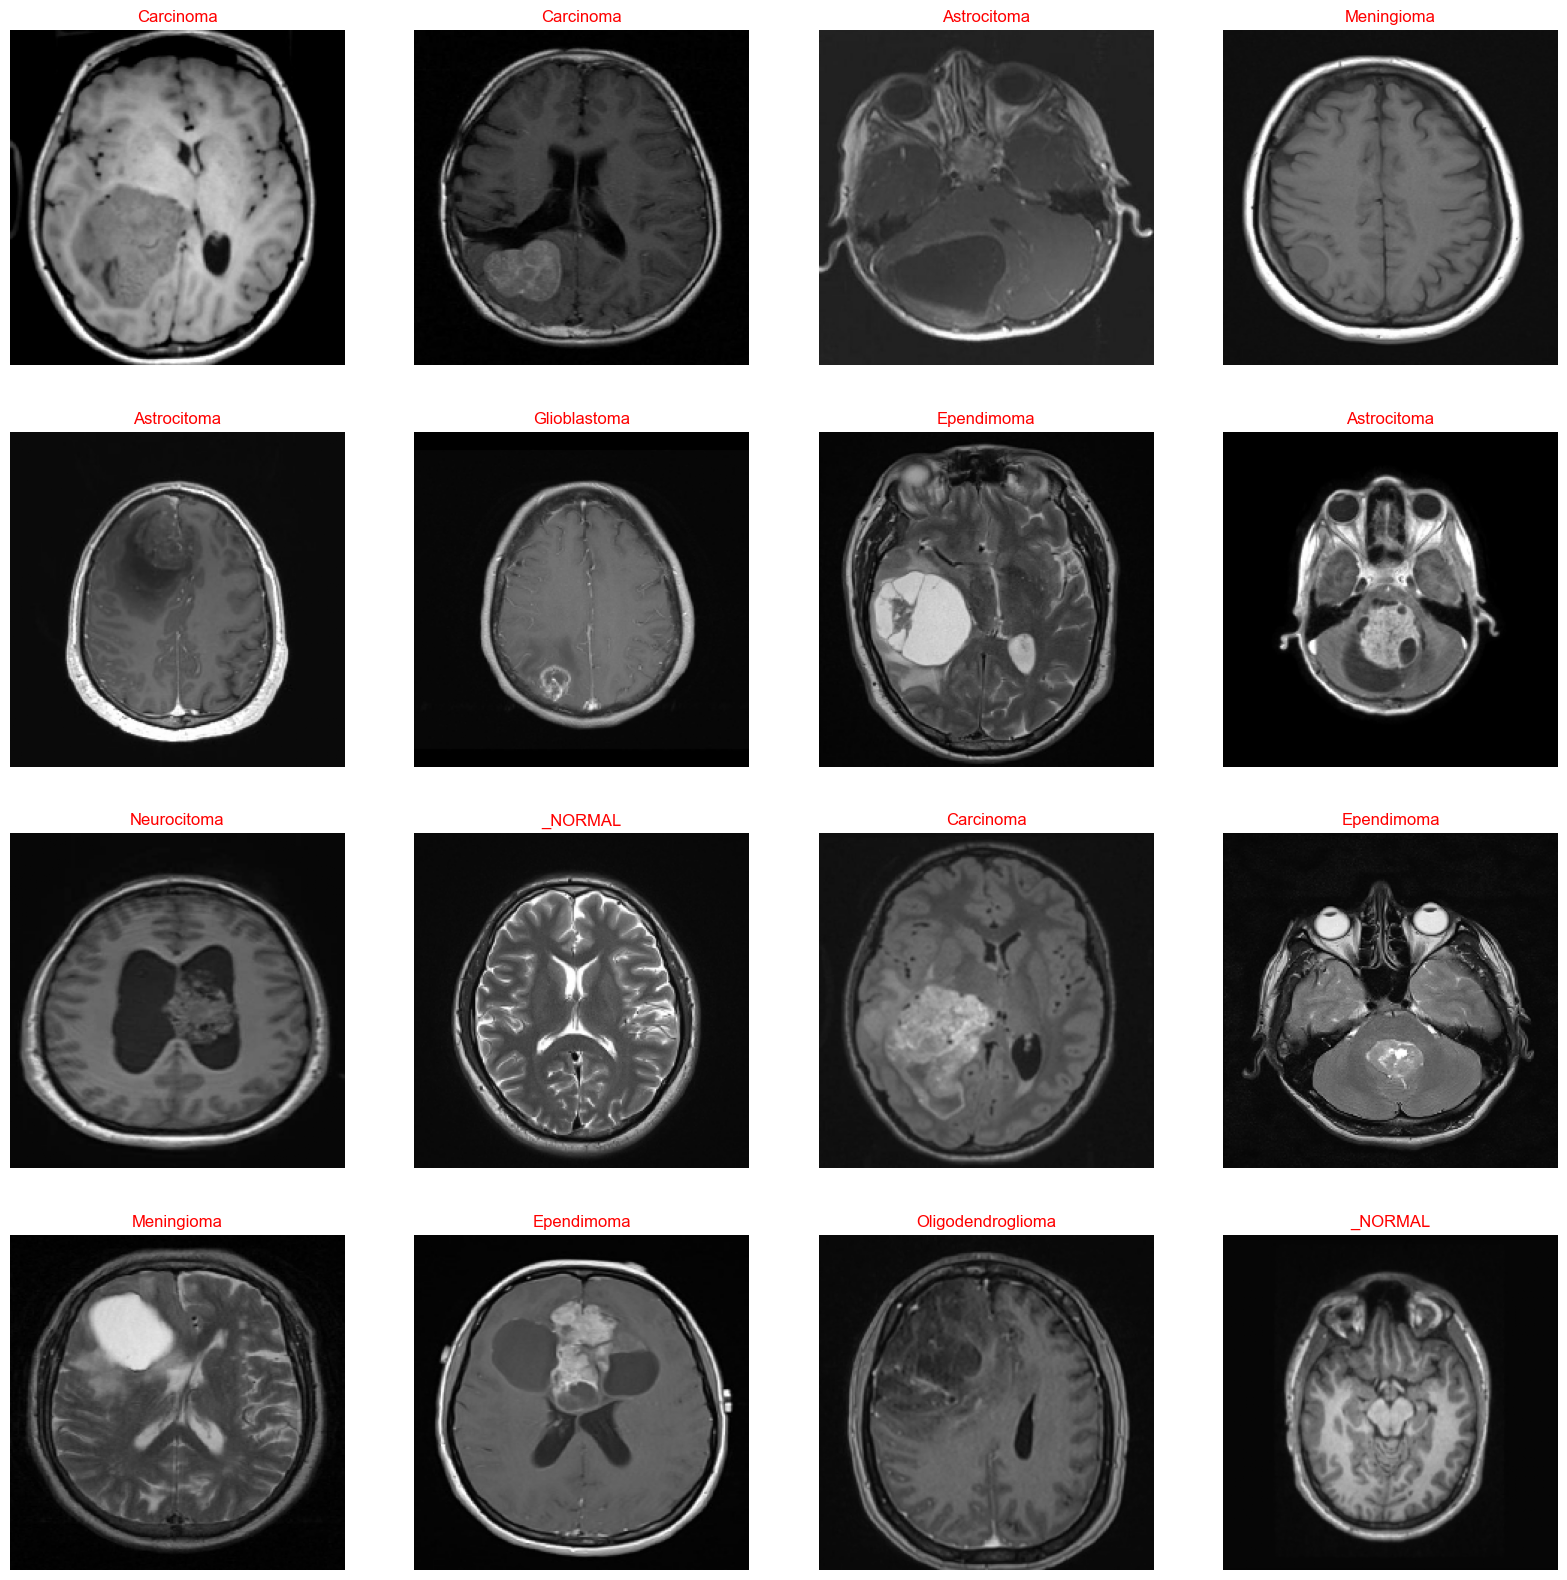

In [8]:
g_dict = train_gen.class_indices
classes= list(g_dict.keys())

images, labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range (16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index= np.argmax(labels[i]) #[0,0,0,1,0]
    class_name = classes[index]
    plt.title(class_name,c='r', fontsize=12)
    plt.axis('off')
plt.show()

In [11]:
image_size = (224, 224)
channels = 3
image_shape = (image_size[0], image_size[1], channels)

base_model = tf.keras.applications.DenseNet169(include_top=False,
                                               weights='imagenet',
                                               input_shape=image_shape,
                                               pooling='max')

model = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, 
          kernel_regularizer=regularizers.l2(0.016), 
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), 
          activation='relu'),
    
    Dropout(rate=0.3),
    Dense(15, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet169 (Functional)        │ (None, 1664)           │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1664)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1664)           │         6,656 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       426,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,079,631 (49.89 MB)

 Trainable params: 12,917,903 (49.28 MB)

 Non-trainable params: 161,728 (631.75 KB)

In [12]:
hist= model.fit(train_gen, epochs= 20, verbose= 1, validation_data= valid_gen, shuffle= False )

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 842s 7s/step - accuracy: 0.1754 - loss: 13.4721 - val_accuracy: 0.1387 - val_loss: 10.5736
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 3340s 30s/step - accuracy: 0.1938 - loss: 6.0923 - val_accuracy: 0.1857 - val_loss: 6.1039
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1882s 17s/step - accuracy: 0.1938 - loss: 5.3506 - val_accuracy: 0.2058 - val_loss: 5.1819
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 800s 7s/step - accuracy: 0.1861 - loss: 4.8572 - val_accuracy: 0.1969 - val_loss: 4.5786
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 808s 7s/step - accuracy: 0.1926 - loss: 4.4569 - val_accuracy: 0.1969 - val_loss: 4.2342
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 792s 7s/step - accuracy: 0.1882 - loss: 4.1244 - val_accuracy: 0.1969 - val_loss: 3.9062
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 782s 7s/step - accuracy: 0.1800 - loss: 3.8431 - val_accuracy: 0.1969 - val_loss: 3.7903
Epoch 8/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 799s 7s/step - accuracy: 0.1945 - loss: 3.6027 - va

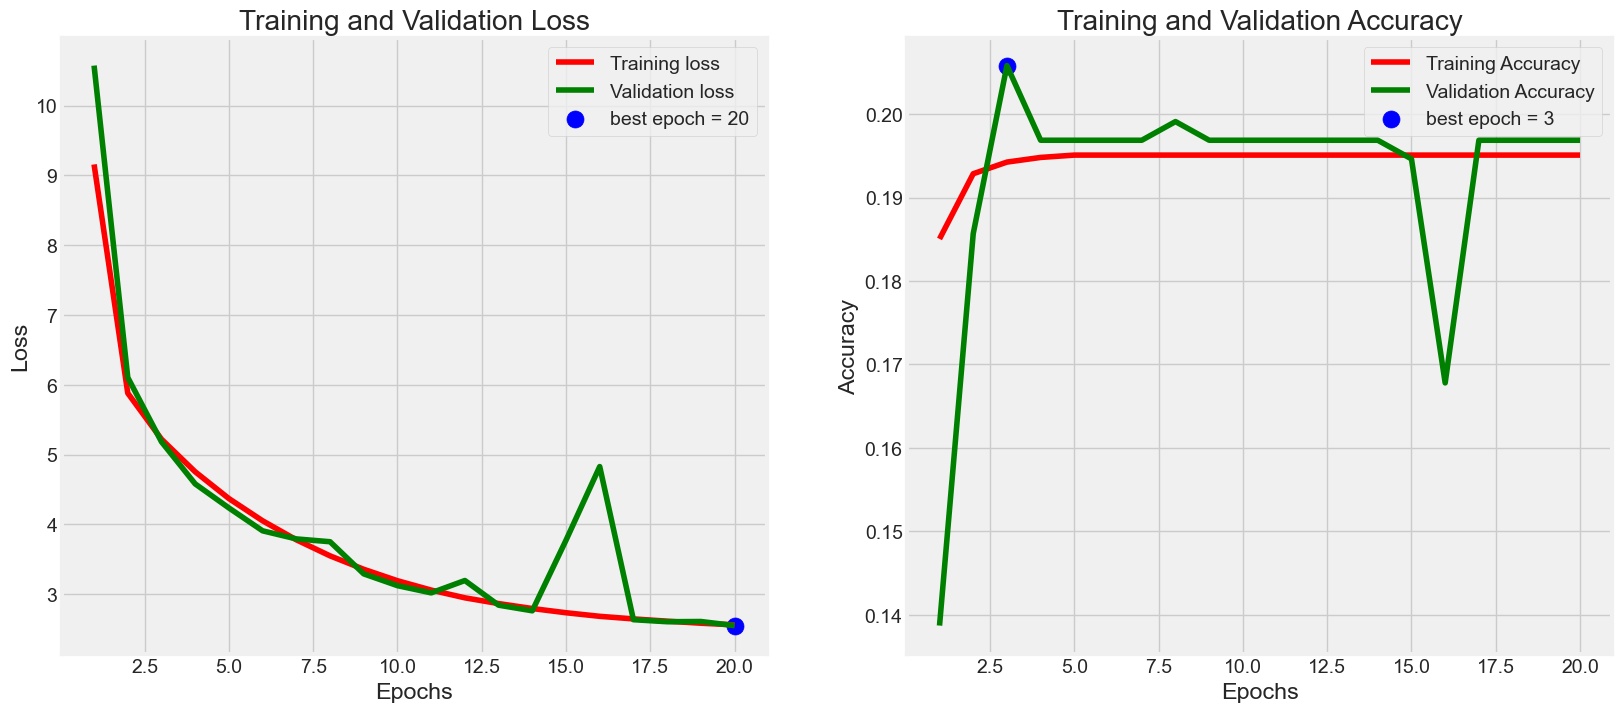

In [13]:
# Define needed variables

tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch = {str(index_loss + 1)}'
acc_label = f'best epoch = {str(index_acc + 1)}'

# Plot training history

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label = 'Training loss')
plt.plot(Epochs, val_loss, 'g', label = 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [14]:
train_score= model.evaluate(train_gen)
valid_score= model.evaluate(valid_gen)
test_score=  model.evaluate(test_gen)

112/112 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.1954 - loss: 2.5498
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.1761 - loss: 2.5444
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.1865 - loss: 2.5426


In [15]:
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('=' * 20)
print( )
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('=' * 20)
print( )
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

Train Loss:  2.548126459121704
Train Accuracy:  0.19508790969848633

Valid Loss:  2.548353433609009
Valid Accuracy:  0.19686800241470337

Test Loss:  2.547663927078247
Test Accuracy:  0.1941964328289032
